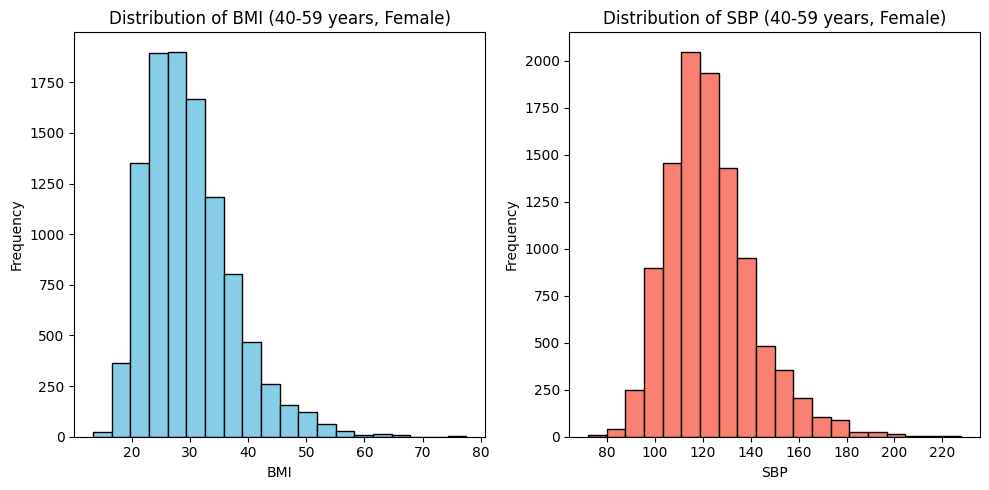

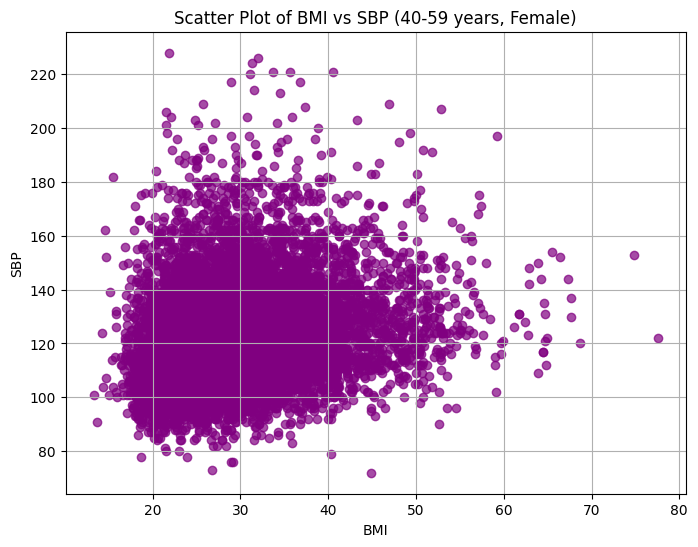

,bmi,sbp
count,10322.000000,10322.000000
mean,29.871992,122.845056
std,7.452950,18.208193
min,13.310609,72.000000
25%,24.390026,110.000000
50%,28.749463,120.000000
75%,33.884874,132.000000
max,77.525831,228.000000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
from Samplers.gibbs_sampler import *
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv')
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']]

# Plot BMI and SBP distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(bmi_sbp_data['bmi'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of BMI (40-59 years, Female)')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(bmi_sbp_data['sbp'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of SBP (40-59 years, Female)')
plt.xlabel('SBP')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot between BMI and SBP
plt.figure(figsize=(8, 6))
plt.scatter(bmi_sbp_data['bmi'], bmi_sbp_data['sbp'], alpha=0.7, color='purple')
plt.title('Scatter Plot of BMI vs SBP (40-59 years, Female)')
plt.xlabel('BMI')
plt.ylabel('SBP')
plt.grid()
plt.show()

# Display filtered data summary
bmi_sbp_summary = bmi_sbp_data.describe()
bmi_sbp_summary


In [2]:
def h1(mu):
    h = np.min([np.linalg.norm(mu[i] - mu[j]) for i in range(len(mu)) for j in range(len(mu)) if i != j])
    return h

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Define BMI and SBP interval bounds
    bmi_bounds = np.array([18, 25, 30, np.inf])
    sbp_bounds = np.array([120, 140, np.inf])
    
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0



Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 500/500 [00:33<00:00, 14.75it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 500/500 [00:33<00:00, 15.03it/s]


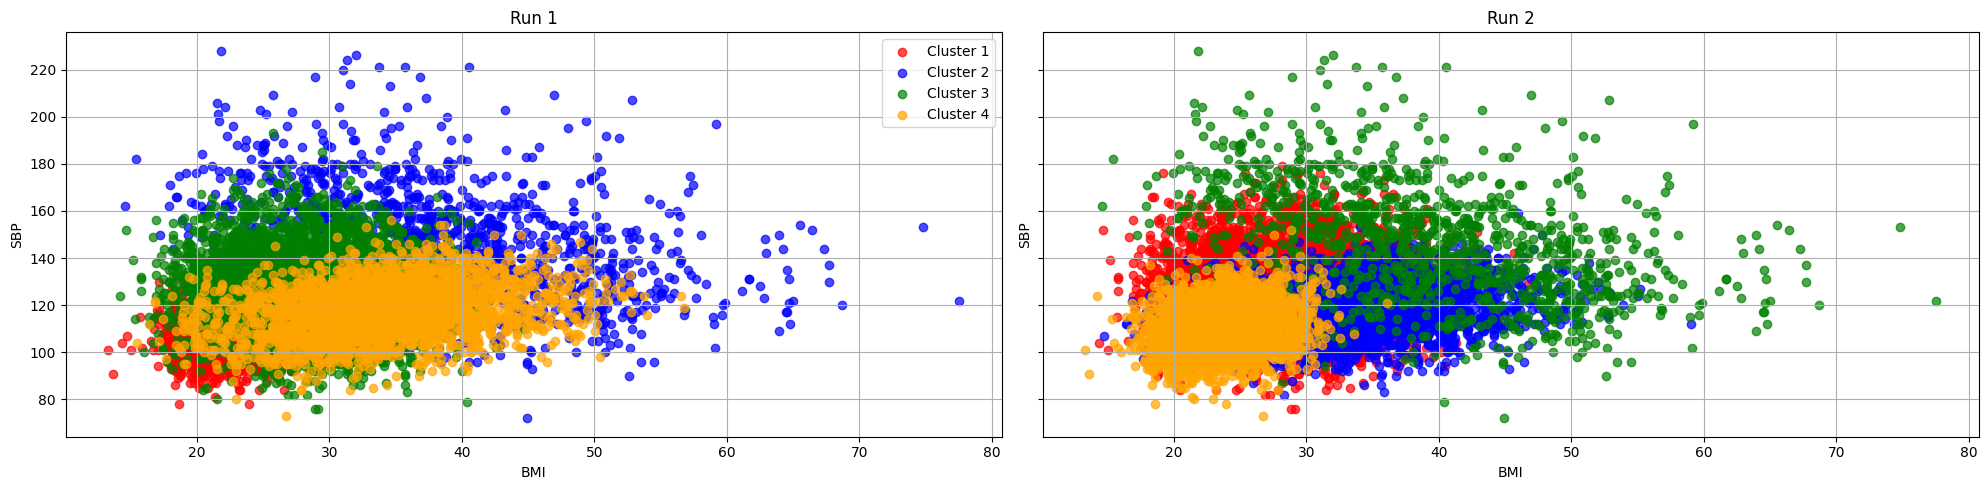

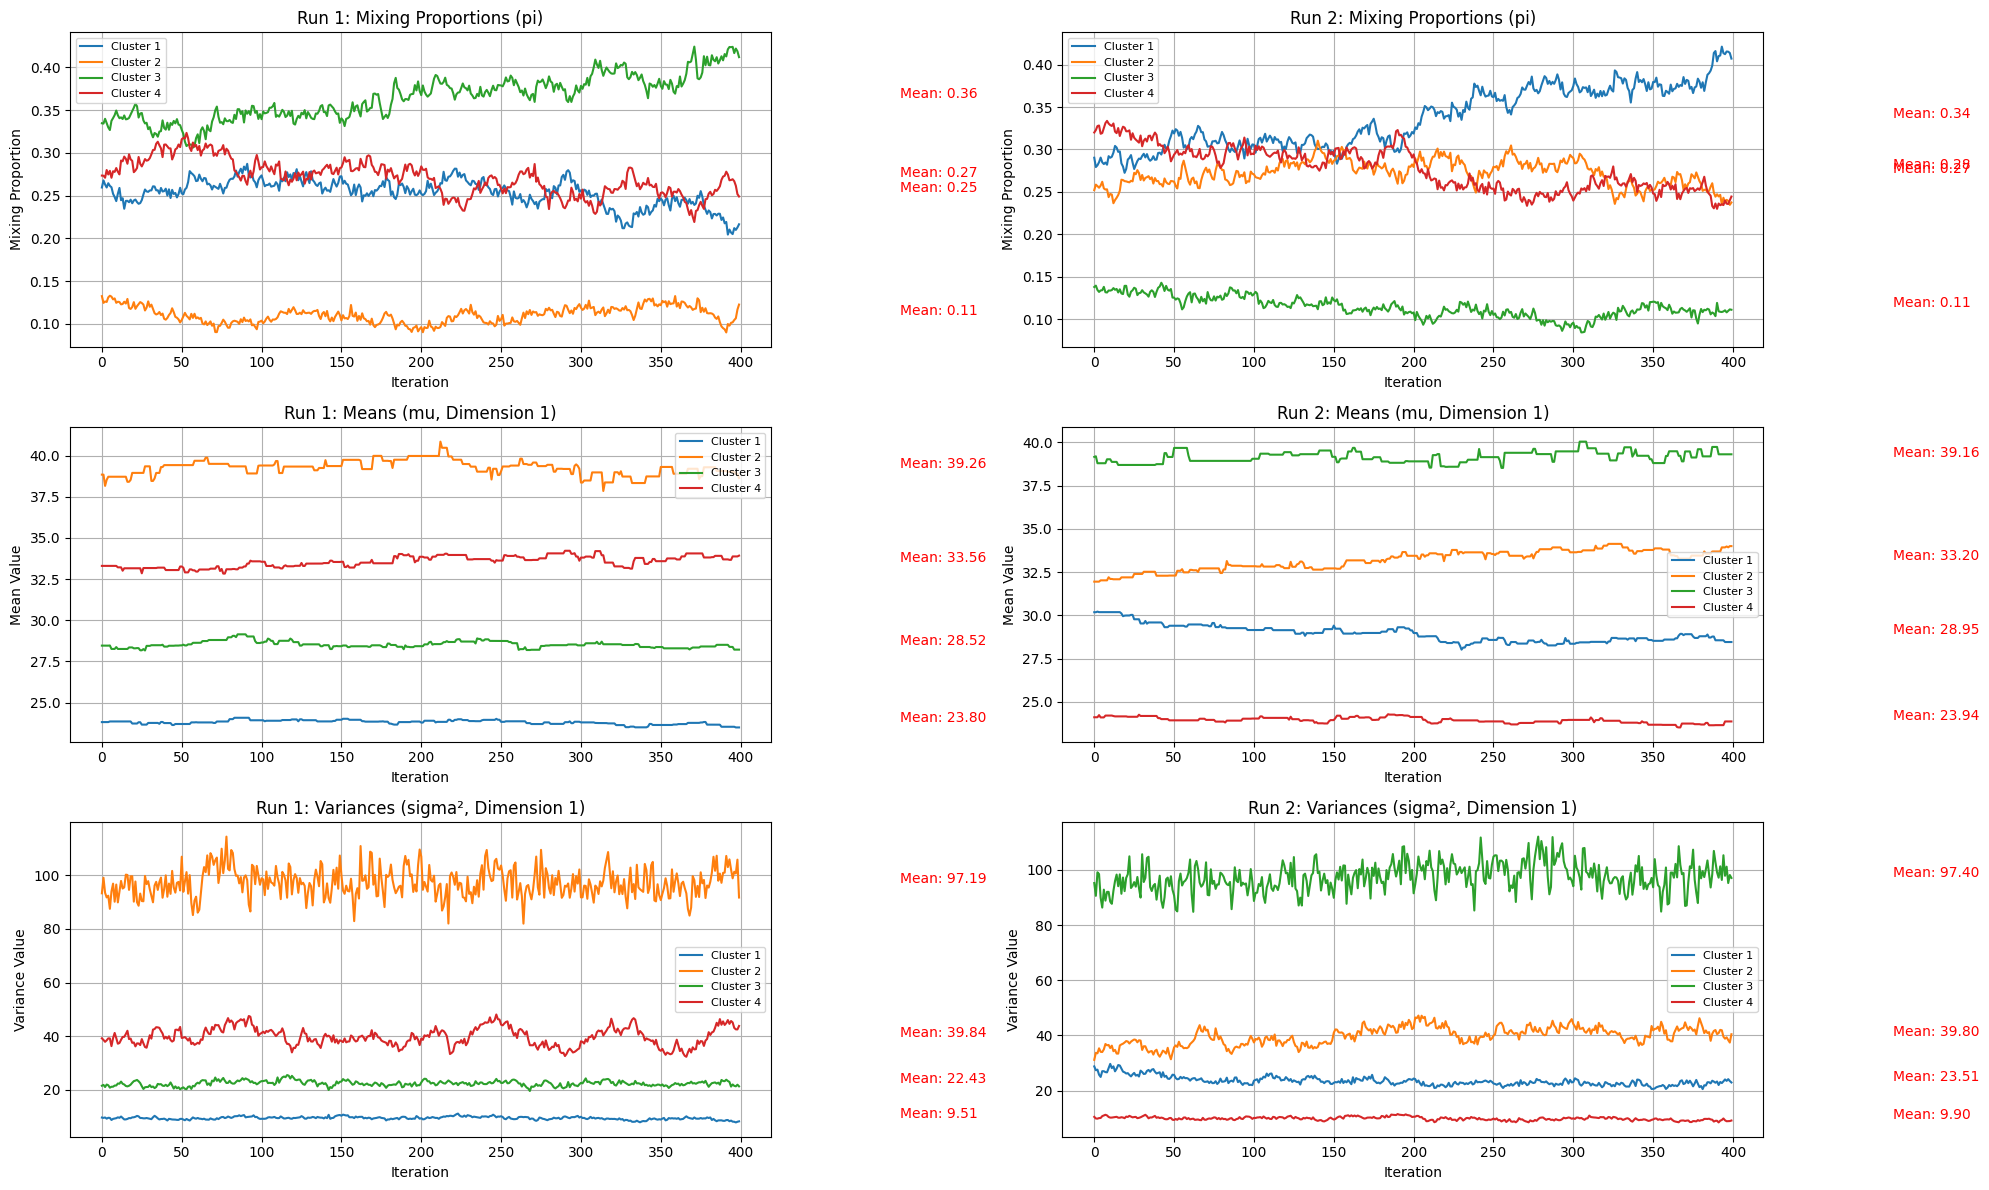

In [3]:
# Parameters
num_runs = 2
num_iterations = 500
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy()

# Store all iterations for each run
all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h2)
    all_run_samples.append(run_samples)  # Store all iterations for the current run

# Plot results for the last iteration of each run
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
fig, axes = plt.subplots(1, num_runs, figsize=(20, 5), sharex=True, sharey=True)

for run, ax in enumerate(axes):
    last_sample = all_run_samples[run][-1]  # Get the last iteration for the current run
    _, _, _, z = last_sample  # Extract z (cluster assignments)
    for k in range(K):
        ax.scatter(
            X[np.array(z) == k, 0],
            X[np.array(z) == k, 1],
            alpha=0.7,
            color=colors[k],
            label=f"Cluster {k+1}" if run == 0 else None,  # Only label in the first plot
        )
    ax.set_title(f"Run {run + 1}")
    ax.set_xlabel("BMI")
    ax.set_ylabel("SBP")
    ax.grid()

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

# --- Trace Plots for Multiple Runs ---
fig, axes = plt.subplots(3, num_runs, figsize=(20, 12))  # 3 rows (pi, mu, sigma²), 5 columns (runs)

# Plot for each run
for run in range(num_runs):
    run_samples = all_run_samples[run]
    pi_samples = np.array([s[0] for s in run_samples])  # Mixing proportions
    mu_samples = np.array([s[1] for s in run_samples])  # Means
    sigma_samples = np.array([s[2] for s in run_samples])  # Covariances

    # --- First Row: Trace Plots for Mixing Proportions (pi) ---
    for k in range(K):
        axes[0, run].plot(pi_samples[:, k], label=f'Cluster {k + 1}')
        axes[0, run].text(num_iterations, np.mean(pi_samples[:, k]), f"Mean: {np.mean(pi_samples[:, k]):.2f}", color='red')
    axes[0, run].set_title(f"Run {run + 1}: Mixing Proportions (pi)")
    axes[0, run].set_xlabel("Iteration")
    axes[0, run].set_ylabel("Mixing Proportion")
    axes[0, run].legend(fontsize=8)
    axes[0, run].grid()

    # --- Second Row: Trace Plots for Means (mu, Dimension 1) ---
    for k in range(K):
        axes[1, run].plot(mu_samples[:, k, 0], label=f'Cluster {k + 1}')  # Only plot Dimension 1
        axes[1, run].text(num_iterations, np.mean(mu_samples[:, k, 0]), f"Mean: {np.mean(mu_samples[:, k, 0]):.2f}", color='red')
    axes[1, run].set_title(f"Run {run + 1}: Means (mu, Dimension 1)")
    axes[1, run].set_xlabel("Iteration")
    axes[1, run].set_ylabel("Mean Value")
    axes[1, run].legend(fontsize=8)
    axes[1, run].grid()

    # --- Third Row: Trace Plots for Variances (sigma², Dimension 1) ---
    for k in range(K):
        variances = [sigma_samples[i, k, 0, 0] for i in range(len(sigma_samples))]  # Variance of Dimension 1
        axes[2, run].plot(variances, label=f'Cluster {k + 1}')
        axes[2, run].text(num_iterations, np.mean(variances), f"Mean: {np.mean(variances):.2f}", color='red')
    axes[2, run].set_title(f"Run {run + 1}: Variances (sigma², Dimension 1)")
    axes[2, run].set_xlabel("Iteration")
    axes[2, run].set_ylabel("Variance Value")
    axes[2, run].legend(fontsize=8)
    axes[2, run].grid()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 5000/5000 [05:32<00:00, 15.03it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 5000/5000 [05:37<00:00, 14.81it/s]


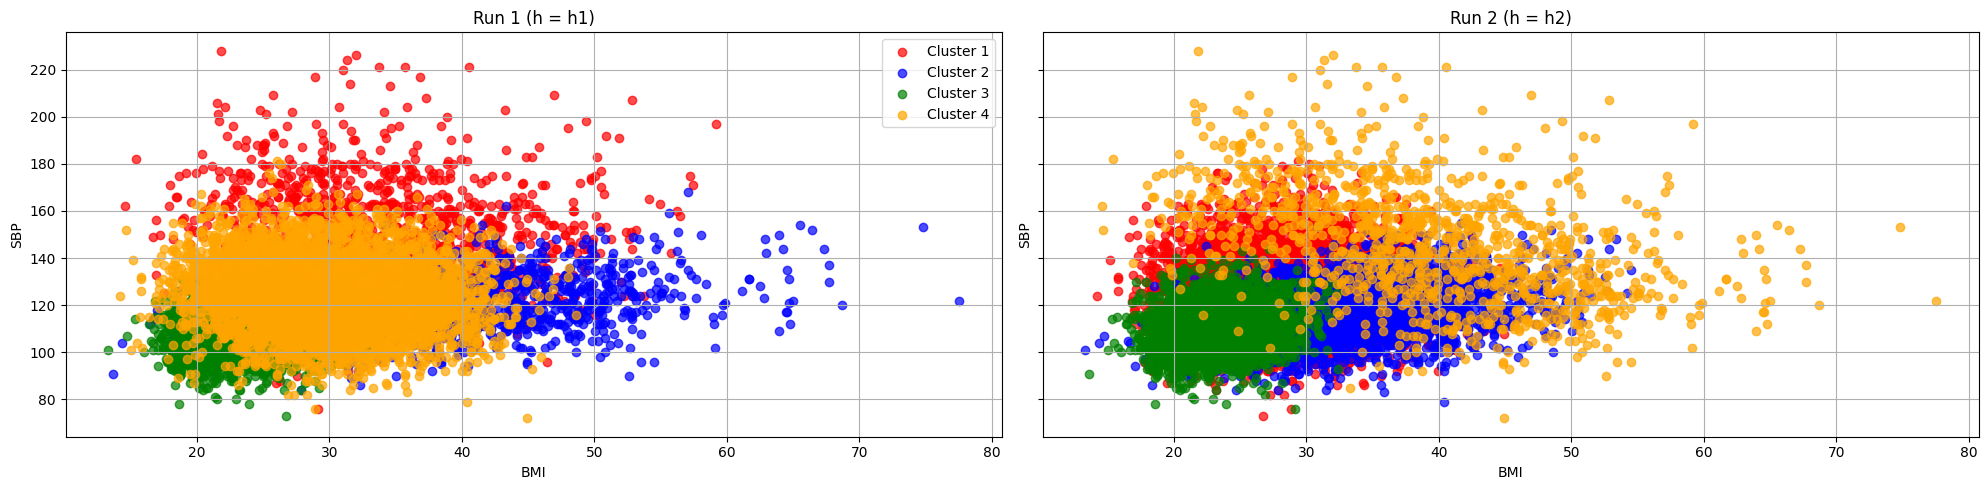

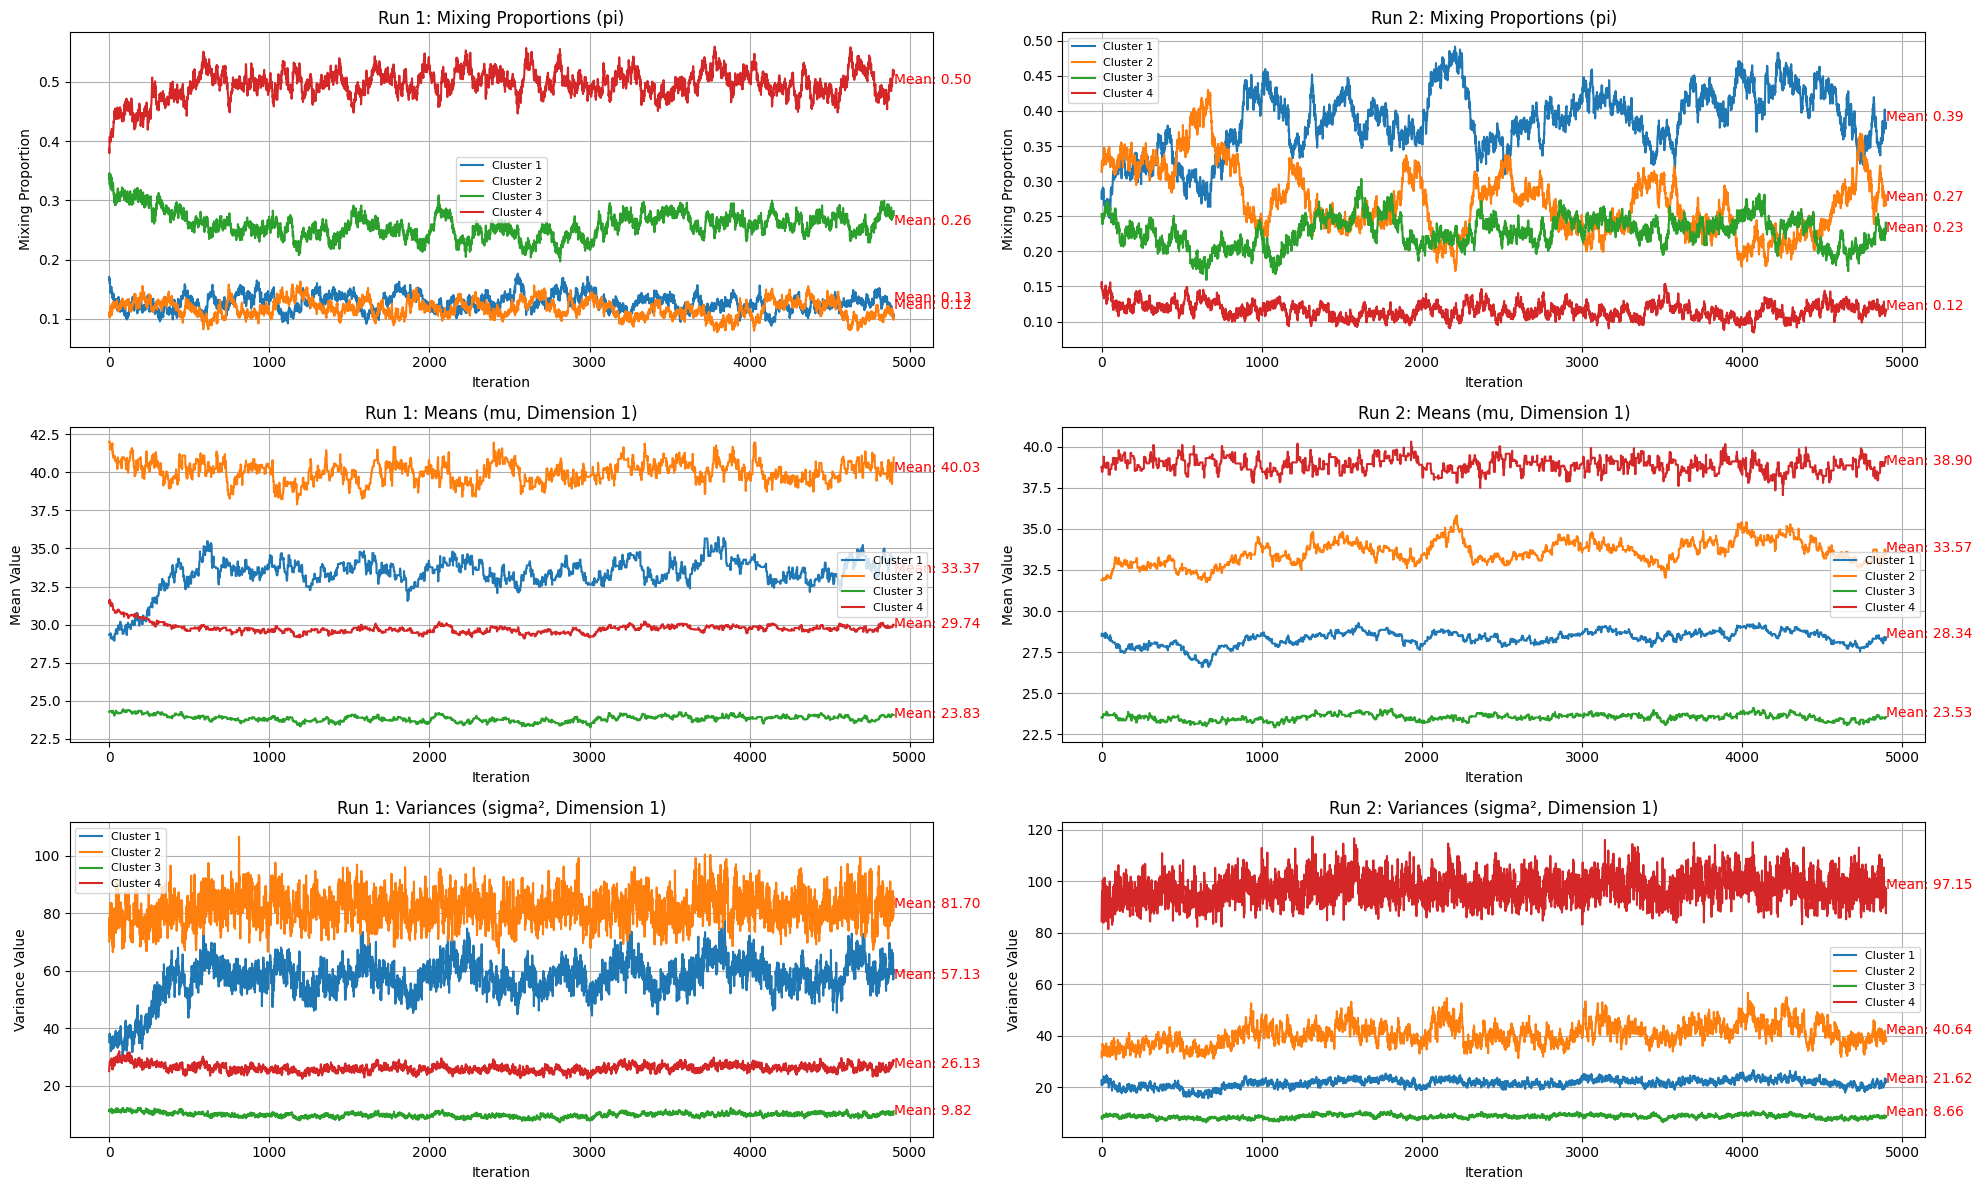

In [4]:

# Parameters
num_runs = 2
num_iterations = 5000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy()


# Store all iterations for each run
all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    h = h1 if run == 0 else h2  # Use h1 for run 1 and h2 for run 2
    run_samples = bayesian_repulsive(X, K, num_iterations, h)  # Run the sampler with the chosen h
    all_run_samples.append(run_samples)  # Store all iterations for the current run

# Plot results for the last iteration of each run
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
fig, axes = plt.subplots(1, num_runs, figsize=(20, 5), sharex=True, sharey=True)

for run, ax in enumerate(axes):
    last_sample = all_run_samples[run][-1]  # Get the last iteration for the current run
    _, _, _, z = last_sample  # Extract z (cluster assignments)
    for k in range(K):
        ax.scatter(
            X[np.array(z) == k, 0],
            X[np.array(z) == k, 1],
            alpha=0.7,
            color=colors[k],
            label=f"Cluster {k+1}" if run == 0 else None,  # Only label in the first plot
        )
    ax.set_title(f"Run {run + 1} (h = {'h1' if run == 0 else 'h2'})")
    ax.set_xlabel("BMI")
    ax.set_ylabel("SBP")
    ax.grid()

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

# --- Trace Plots for Multiple Runs ---
fig, axes = plt.subplots(3, num_runs, figsize=(20, 12))  # 3 rows (pi, mu, sigma²), num_runs columns

# Plot for each run
for run in range(num_runs):
    run_samples = all_run_samples[run]
    pi_samples = np.array([s[0] for s in run_samples])  # Mixing proportions
    mu_samples = np.array([s[1] for s in run_samples])  # Means
    sigma_samples = np.array([s[2] for s in run_samples])  # Covariances

    # --- First Row: Trace Plots for Mixing Proportions (pi) ---
    for k in range(K):
        axes[0, run].plot(pi_samples[:, k], label=f'Cluster {k + 1}')
        axes[0, run].text(len(pi_samples), np.mean(pi_samples[:, k]), f"Mean: {np.mean(pi_samples[:, k]):.2f}", color='red')
    axes[0, run].set_title(f"Run {run + 1}: Mixing Proportions (pi)")
    axes[0, run].set_xlabel("Iteration")
    axes[0, run].set_ylabel("Mixing Proportion")
    axes[0, run].legend(fontsize=8)
    axes[0, run].grid()

    # --- Second Row: Trace Plots for Means (mu, Dimension 1) ---
    for k in range(K):
        axes[1, run].plot(mu_samples[:, k, 0], label=f'Cluster {k + 1}')  # Only plot Dimension 1
        axes[1, run].text(len(mu_samples), np.mean(mu_samples[:, k, 0]), f"Mean: {np.mean(mu_samples[:, k, 0]):.2f}", color='red')
    axes[1, run].set_title(f"Run {run + 1}: Means (mu, Dimension 1)")
    axes[1, run].set_xlabel("Iteration")
    axes[1, run].set_ylabel("Mean Value")
    axes[1, run].legend(fontsize=8)
    axes[1, run].grid()

    # --- Third Row: Trace Plots for Variances (sigma², Dimension 1) ---
    for k in range(K):
        variances = [sigma_samples[i, k, 0, 0] for i in range(len(sigma_samples))]  # Variance of Dimension 1
        axes[2, run].plot(variances, label=f'Cluster {k + 1}')
        axes[2, run].text(len(variances), np.mean(variances), f"Mean: {np.mean(variances):.2f}", color='red')
    axes[2, run].set_title(f"Run {run + 1}: Variances (sigma², Dimension 1)")
    axes[2, run].set_xlabel("Iteration")
    axes[2, run].set_ylabel("Variance Value")
    axes[2, run].legend(fontsize=8)
    axes[2, run].grid()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

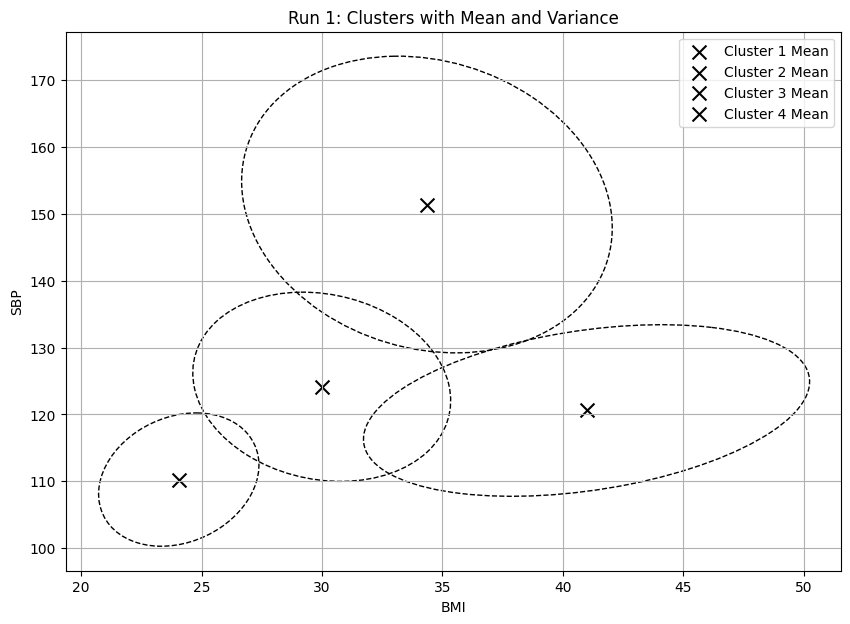

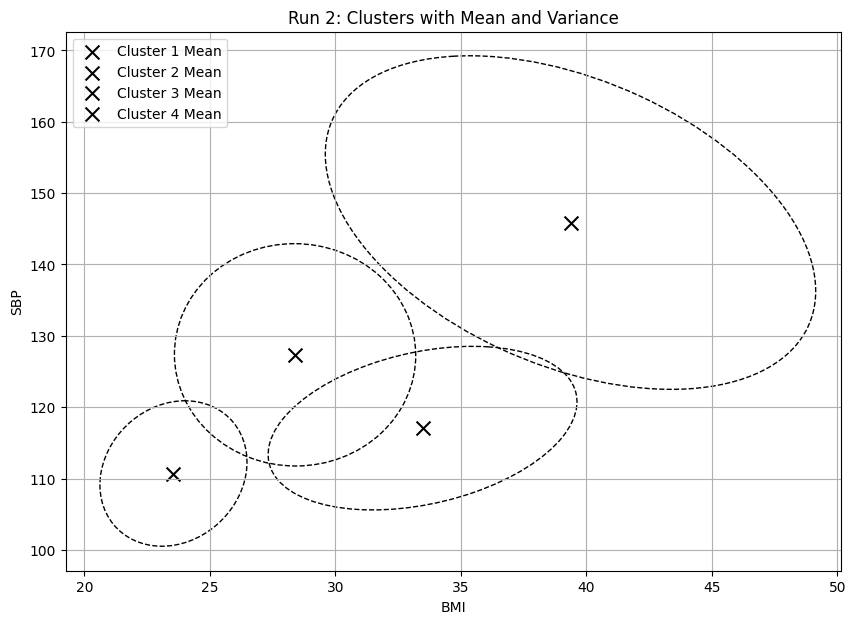

In [5]:

# Plot the mean and variance (as ellipses) for each run
for run, run_samples in enumerate(all_run_samples):
    last_sample = run_samples[-1]
    pi, mu, sigma, z = last_sample  # Extract parameters from the last iteration

    plt.figure(figsize=(10, 7))
    plt.title(f"Run {run + 1}: Clusters with Mean and Variance")
    plt.xlabel("BMI")
    plt.ylabel("SBP")

    # Scatter the data points
    for k in range(K):
        cluster_points = X[np.array(z) == k]
        # plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.4, label=f"Cluster {k + 1} Data")

        # Plot the mean of the cluster
        plt.scatter(mu[k, 0], mu[k, 1], color='black', s=100, label=f"Cluster {k + 1} Mean", marker='x')

        # Add confidence ellipse for the cluster
        cov_matrix = sigma[k]
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.arctan2(*eigenvectors[:, 0][::-1])
        width, height = 2 * np.sqrt(eigenvalues)  # 1 SD ellipse
        ellipse = patches.Ellipse(
            mu[k], width, height, angle=np.degrees(angle), edgecolor='black', facecolor='none', linestyle='--'
        )
        plt.gca().add_patch(ellipse)

    plt.legend()
    plt.grid()
    plt.show()

Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 300/300 [00:20<00:00, 14.61it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 300/300 [00:20<00:00, 14.53it/s]


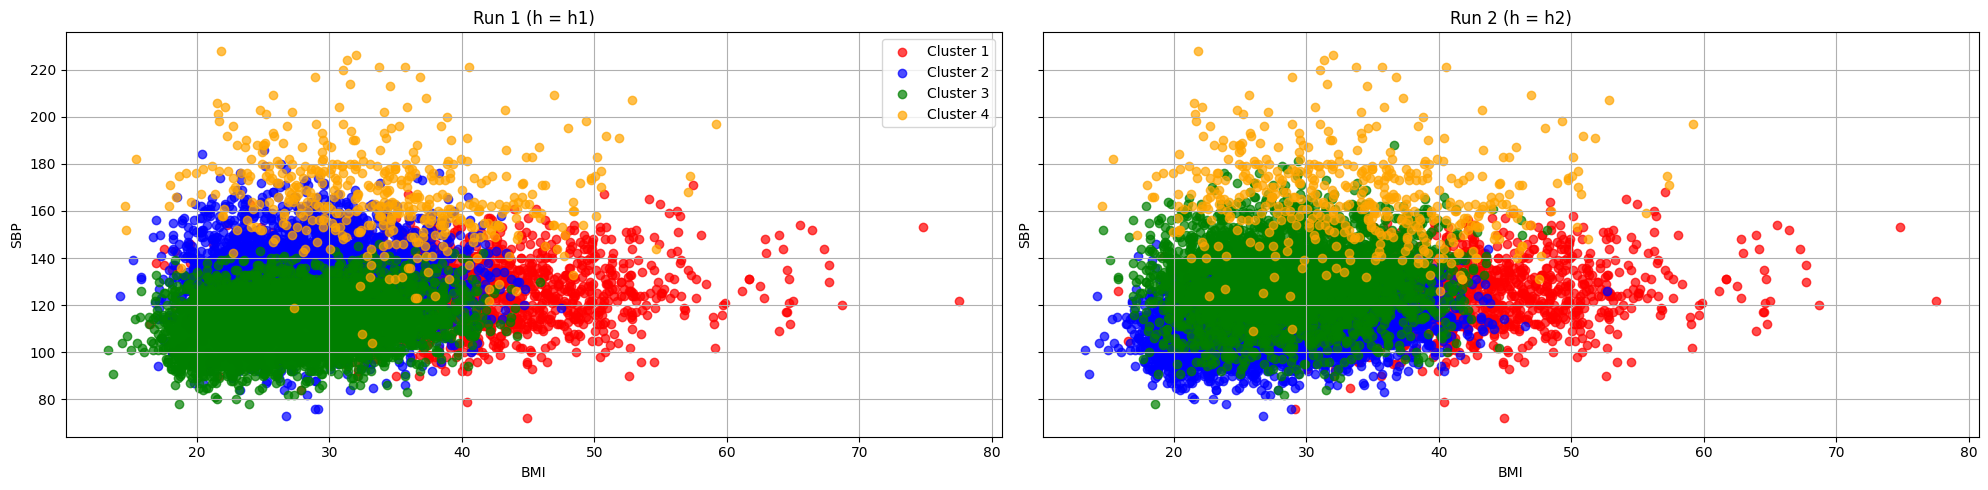

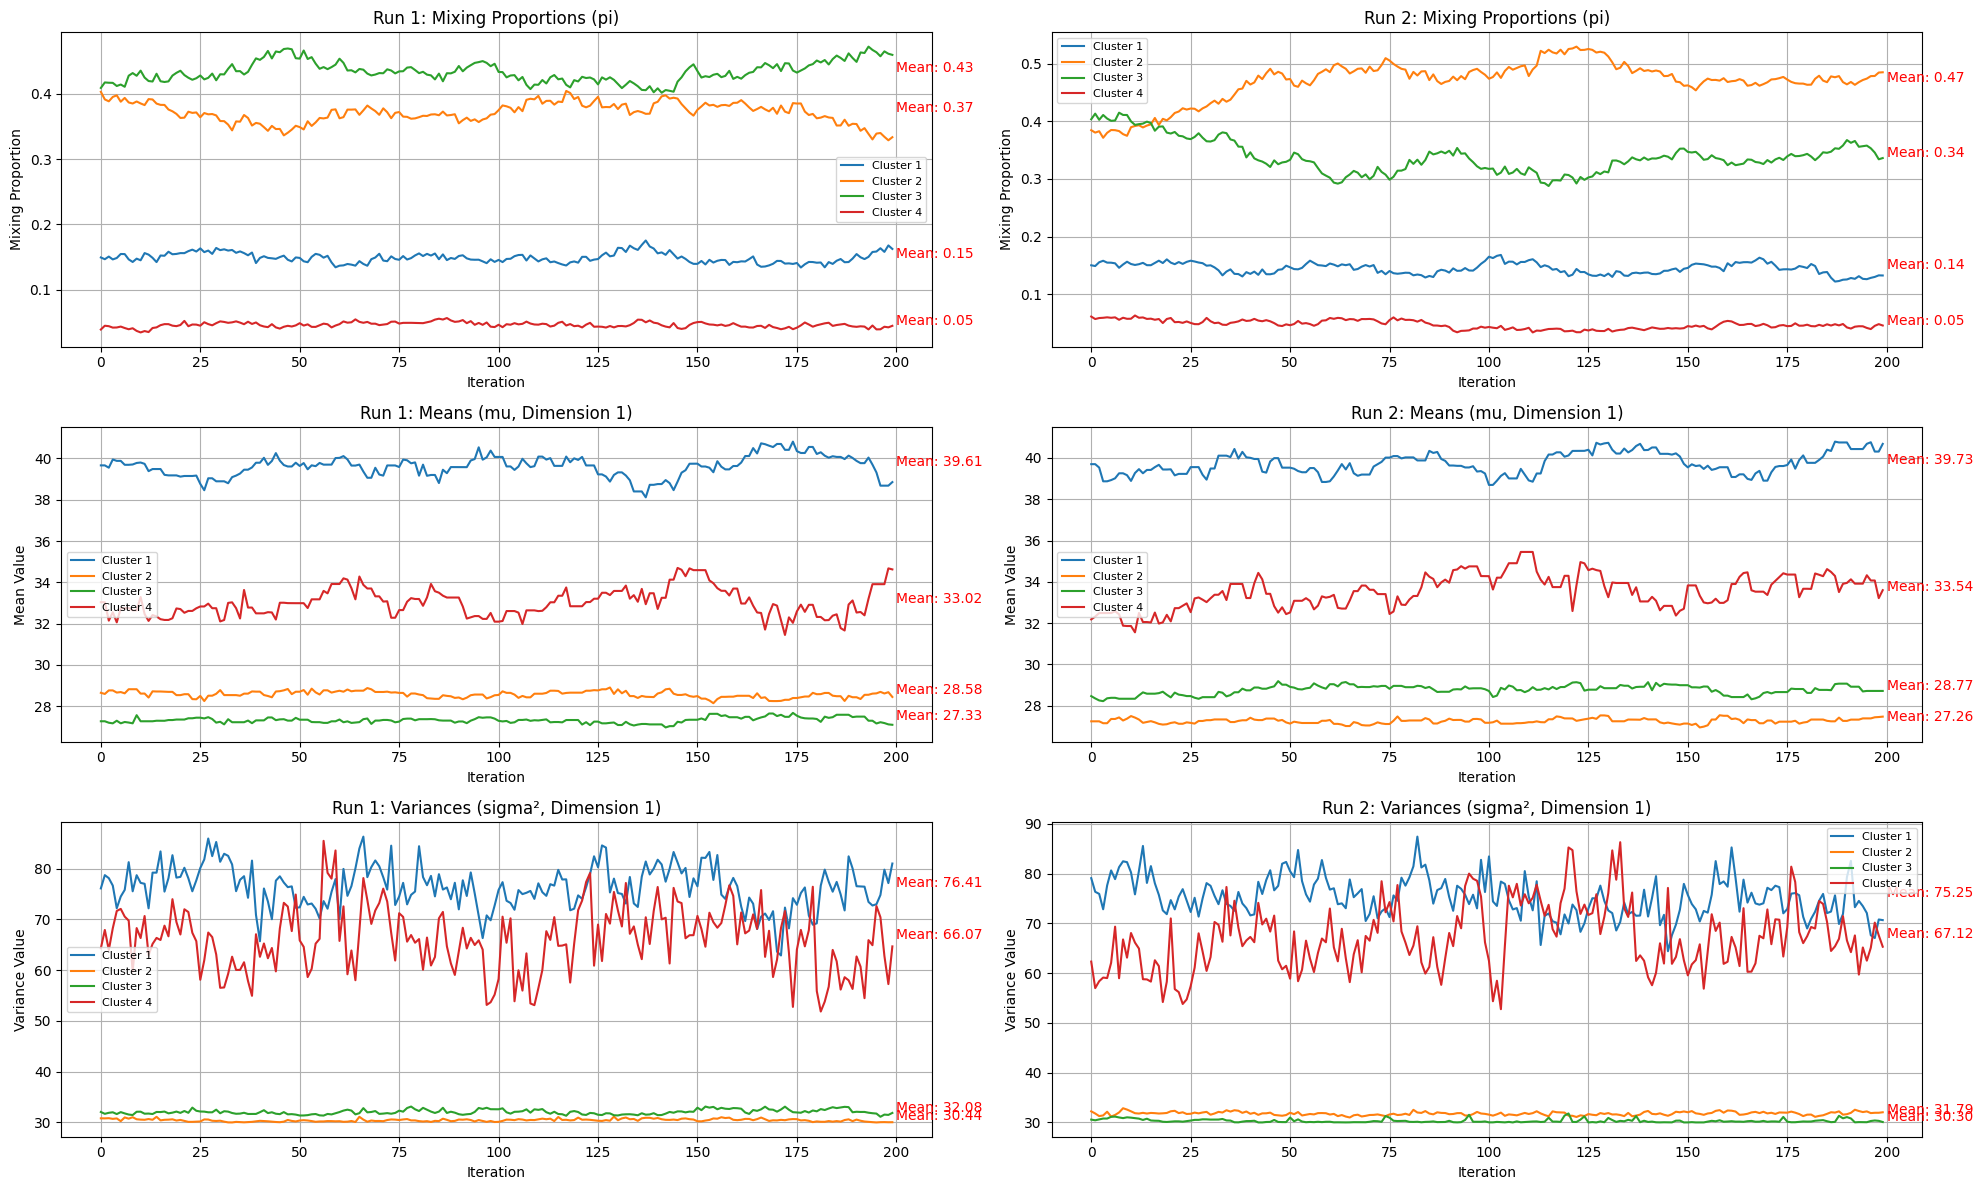

In [6]:
from Samplers.gibbs_sampler import *
# Parameters
num_runs = 2
num_iterations = 5000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy()


# Store all iterations for each run
all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    h = h1 if run == 0 else h2  # Use h1 for run 1 and h2 for run 2
    run_samples = bayesian_repulsive_with_variance_constraint(X, K, num_iterations, h)  # Run the sampler with the chosen h
    all_run_samples.append(run_samples)  # Store all iterations for the current run

# Plot results for the last iteration of each run
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
fig, axes = plt.subplots(1, num_runs, figsize=(20, 5), sharex=True, sharey=True)

for run, ax in enumerate(axes):
    last_sample = all_run_samples[run][-1]  # Get the last iteration for the current run
    _, _, _, z = last_sample  # Extract z (cluster assignments)
    for k in range(K):
        ax.scatter(
            X[np.array(z) == k, 0],
            X[np.array(z) == k, 1],
            alpha=0.7,
            color=colors[k],
            label=f"Cluster {k+1}" if run == 0 else None,  # Only label in the first plot
        )
    ax.set_title(f"Run {run + 1} (h = {'h1' if run == 0 else 'h2'})")
    ax.set_xlabel("BMI")
    ax.set_ylabel("SBP")
    ax.grid()

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

# --- Trace Plots for Multiple Runs ---
fig, axes = plt.subplots(3, num_runs, figsize=(20, 12))  # 3 rows (pi, mu, sigma²), num_runs columns

# Plot for each run
for run in range(num_runs):
    run_samples = all_run_samples[run]
    pi_samples = np.array([s[0] for s in run_samples])  # Mixing proportions
    mu_samples = np.array([s[1] for s in run_samples])  # Means
    sigma_samples = np.array([s[2] for s in run_samples])  # Covariances

    # --- First Row: Trace Plots for Mixing Proportions (pi) ---
    for k in range(K):
        axes[0, run].plot(pi_samples[:, k], label=f'Cluster {k + 1}')
        axes[0, run].text(len(pi_samples), np.mean(pi_samples[:, k]), f"Mean: {np.mean(pi_samples[:, k]):.2f}", color='red')
    axes[0, run].set_title(f"Run {run + 1}: Mixing Proportions (pi)")
    axes[0, run].set_xlabel("Iteration")
    axes[0, run].set_ylabel("Mixing Proportion")
    axes[0, run].legend(fontsize=8)
    axes[0, run].grid()

    # --- Second Row: Trace Plots for Means (mu, Dimension 1) ---
    for k in range(K):
        axes[1, run].plot(mu_samples[:, k, 0], label=f'Cluster {k + 1}')  # Only plot Dimension 1
        axes[1, run].text(len(mu_samples), np.mean(mu_samples[:, k, 0]), f"Mean: {np.mean(mu_samples[:, k, 0]):.2f}", color='red')
    axes[1, run].set_title(f"Run {run + 1}: Means (mu, Dimension 1)")
    axes[1, run].set_xlabel("Iteration")
    axes[1, run].set_ylabel("Mean Value")
    axes[1, run].legend(fontsize=8)
    axes[1, run].grid()

    # --- Third Row: Trace Plots for Variances (sigma², Dimension 1) ---
    for k in range(K):
        variances = [sigma_samples[i, k, 0, 0] for i in range(len(sigma_samples))]  # Variance of Dimension 1
        axes[2, run].plot(variances, label=f'Cluster {k + 1}')
        axes[2, run].text(len(variances), np.mean(variances), f"Mean: {np.mean(variances):.2f}", color='red')
    axes[2, run].set_title(f"Run {run + 1}: Variances (sigma², Dimension 1)")
    axes[2, run].set_xlabel("Iteration")
    axes[2, run].set_ylabel("Variance Value")
    axes[2, run].legend(fontsize=8)
    axes[2, run].grid()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

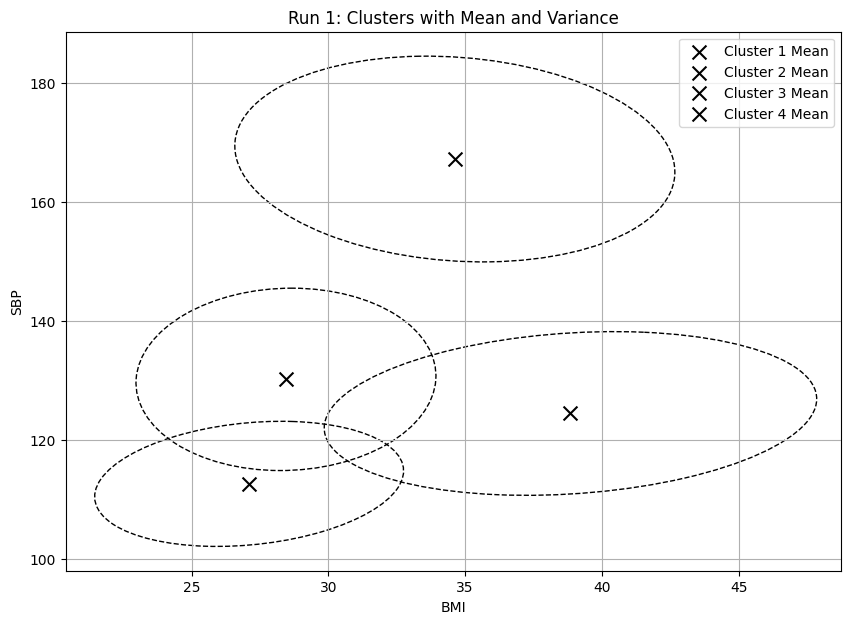

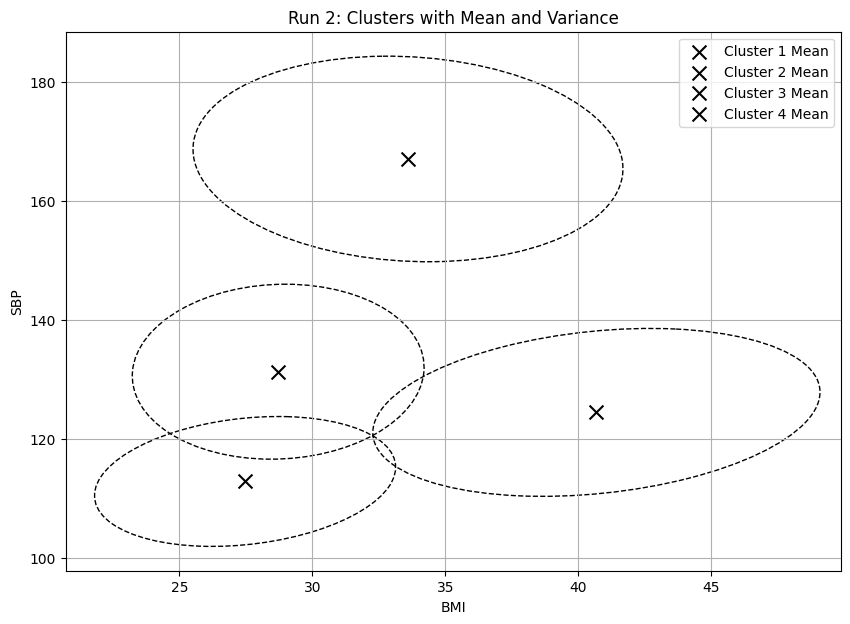

In [7]:

# Plot the mean and variance (as ellipses) for each run
for run, run_samples in enumerate(all_run_samples):
    last_sample = run_samples[-1]
    pi, mu, sigma, z = last_sample  # Extract parameters from the last iteration

    plt.figure(figsize=(10, 7))
    plt.title(f"Run {run + 1}: Clusters with Mean and Variance")
    plt.xlabel("BMI")
    plt.ylabel("SBP")

    # Scatter the data points
    for k in range(K):
        cluster_points = X[np.array(z) == k]
        # plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.4, label=f"Cluster {k + 1} Data")

        # Plot the mean of the cluster
        plt.scatter(mu[k, 0], mu[k, 1], color='black', s=100, label=f"Cluster {k + 1} Mean", marker='x')

        # Add confidence ellipse for the cluster
        cov_matrix = sigma[k]
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.arctan2(*eigenvectors[:, 0][::-1])
        width, height = 2 * np.sqrt(eigenvalues)  # 1 SD ellipse
        ellipse = patches.Ellipse(
            mu[k], width, height, angle=np.degrees(angle), edgecolor='black', facecolor='none', linestyle='--'
        )
        plt.gca().add_patch(ellipse)

    plt.legend()
    plt.grid()
    plt.show()